# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)

# Install necessary libraries
!pip install tomotopy
!pip install little_mallet_wrapper

In [2]:
# Import necessary libraries
import tomotopy as tp  # for topic modeling
import little_mallet_wrapper  # for topic modeling
import seaborn as sns  # for data visualization
import matplotlib.pyplot as plt   # for data visualization
import glob  # for handling files and interacting with the file system
from pathlib import Path  # for handling files and interacting with the file system
import pandas as pd  # for analyzing and processing datasets
import re  # for working with regular expressions (https://docs.python.org/3/library/re.html)

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [3]:
# Q2 (code)
from google.colab import drive  # for accessing Google Drive in Google Colab
drive.mount('/content/drive')  # mount Google Drive to the directory I need in Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the two datasets
sanders_tweets = pd.read_csv('/content/drive/MyDrive/AD_A3_resit/sanders_tweets.csv')
trump_tweets = pd.read_csv('/content/drive/MyDrive/AD_A3_resit/trump_tweets.csv')

# Combine the two datasets
combined_tweets = pd.concat([sanders_tweets, trump_tweets]) # concatenating tweets into a single DataFrame
combined_tweets.reset_index(drop=True, inplace=True) # resetting index for consistency
combined_tweets.head() # displaying first few rows

,Username,TweetId,Title,Content
0,SenSanders,1351670845639421952,SenSanders_1351670845639421952,Wealth increase in past 10 months:\n⬆️$173 bil...
1,SenSanders,1351259762722279424,SenSanders_1351259762722279424,Amidst massive income and wealth inequality te...
2,SenSanders,1351242822293319680,SenSanders_1351242822293319680,"“We now have the resources, we now have the sk..."
3,SenSanders,1350885541911400448,SenSanders_1350885541911400448,"After surviving an attempt on his life, Russia..."
4,SenSanders,1349880150041780224,SenSanders_1349880150041780224,President-Elect Biden's COVID rescue plan will...


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [5]:
# Import necessary libraries
from nltk.corpus import stopwords  # provides stopwords
from nltk.tokenize import word_tokenize  # for tokenization
import string  # for string operations

import nltk  # natural language toolkit
nltk.download('punkt')  # download the Punkt tokenizer models
nltk.download('stopwords')  # download stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
training_data = []  # an empty list for training data
original_texts = []  # an empty list for original text data
titles = []  # an empty list for titles or labels

stop_words = set(stopwords.words('english'))  # set of English stopwords
punctuation = set(string.punctuation)  # set of punctuation characters

In [7]:
for index, row in combined_tweets.iterrows():
    original_text = row['Content'].lower()  # convert text to lowercase
    original_texts.append(original_text)  # add original text to list

    # Remove URLs, mentions, hashtags, and other unwanted patterns from the text
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump|rt", '', original_text, flags=re.MULTILINE)
    words = word_tokenize(processed_text)  # tokenize the processed text

    # Filter out stopwords and non-alphabetic words
    words_filtered = [word for word in words if word not in stop_words and word.isalpha()]

    training_data.append(' '.join(words_filtered))  # add processed text to training data
    titles.append(f"{row['Username']} - {row['TweetId']}")  # create a title for the text

In [8]:
len(training_data), len(original_texts), len(titles)

(30371, 30371, 30371)

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [9]:
# Q4 (code)

# Number of topics to return
num_topics = 10
# Numer of topic words to print out
num_topic_words = 15

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())
print("Topic Model Training...\n\n")

# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.122256904750186
Iteration: 10	Log-likelihood: -8.739192750196343
Iteration: 20	Log-likelihood: -8.581170445037591
Iteration: 30	Log-likelihood: -8.505392920007262
Iteration: 40	Log-likelihood: -8.45469828798075
Iteration: 50	Log-likelihood: -8.423895647961775
Iteration: 60	Log-likelihood: -8.399978439199693
Iteration: 70	Log-likelihood: -8.384000611839783
Iteration: 80	Log-likelihood: -8.370723547111051
Iteration: 90	Log-likelihood: -8.362667358740858


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [10]:
# Q5a (code)

# Print out top 15 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

border must amp law people president national trump today american federal government stand security country

✨Topic 1✨

president great jobs america economy trump amp country ever history years american back since new

✨Topic 2✨

trump fbi russia amp collusion witch mueller hunt campaign hillary repo obama clinton president investigation

✨Topic 3✨

biden joe trump would new president york amp years like even sleepy pay china get

✨Topic 4✨

democrats president election vote house impeachment people senate trump want republicans nothing cou amp republican

✨Topic 5✨

health care people must need tax right americans trump country million republicans bill make american

✨Topic 6✨

great thank state amp vote total big endorsement job america strong military maga today complete

✨Topic 7✨

united states china trade president deal war great many amp us iran world countries mexico

✨Topic 8✨

news fake media amp people good bad never even big much many gre

In [11]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

**Topic 0: Border Security, Law Enforcement, National Security**   
This topic revolves around discussions related to border security, law enforcement, and national security, particularly in the context of the United States. Phrases like "border must," "law," and "national security" indicate a focus on policies and actions aimed at ensuring the security and integrity of the country's borders and legal framework. References to "people," "president," and "federal government" suggest discussions about leadership, policies, and actions taken by government officials, particularly the president, to address security concerns. The inclusion of terms like "today," "American," and "stand" reflects ongoing debates and actions regarding the country's security stance in contemporary times. Overall, this topic highlights issues related to border security, law enforcement, and national security evaluations.

**Topic 1: Economic Prosperity, Job Creation, American Identity**  
This topic discusses themes of economic growth and job creation within the context of American identity. References to "president," "great," and "jobs" suggest a focus on policies aimed at enhancing the economy and employment opportunities. Terms like "America" and "country" underscore discussions about national economic prosperity. Phrases like "history" and "years" indicate reflections on past economic trends. Overall, this topic emphasizes the importance of economic vitality and its role in shaping the American narrative.

**Topic 2: Trump-Russia Investigation, FBI, Political Campaigns**   
This topic explores discussions surrounding the Trump-Russia investigation, the FBI, and political campaigns, particularly during the 2016 election. References to "Trump," "FBI," "Russia," and "collusion" suggest a focus on allegations and inquiries related to potential interference in the election. Terms like "Mueller" and "investigation" highlight ongoing scrutiny and legal proceedings. Overall, this topic encapsulates the complexities of political intrigue and legal scrutiny surrounding these interconnected issues.

**Topic 3: Biden vs. Trump, Presidential Election, Policy Proposals**  
This topic compares Joe Biden and Donald Trump in the context of the presidential race. References to "Biden," "Trump," and "president" suggest discussions about their candidacy and policies. Terms like "New York" and "years" may reflect past experiences or political backgrounds. Overall, this topic encapsulates the ongoing debate and analysis surrounding the upcoming election.

**Topic 4: Immigration, Environmental Policy, National Unity**   
This topic discusses immigration policies, environmental concerns, and national unity. Keywords like "border," "wall," and "climate" suggest debates on immigration and environmental policies. References to "together" and "stop" indicate calls for collective action. Mentions of "Trump" suggest discussions on presidential policies. Overall, the topic highlights concerns about immigration, environmental protection, and national unity in the context of Trump's administration.

**Topic 5: Politics, Democrats vs. Republicans, Impeachment**  
This topic covers discussions on politics, focusing on Democrats, Republicans, and the impeachment process. References to "election," "vote," and "impeachment" highlight political activities and procedures. Terms like "want" and "nothing" may signify contrasting political goals. Overall, it captures the dynamic nature of partisan politics.

**Topic 6: Campaign Rhetoric, Patriotism, Endorsements**   
This topic revolves around campaign rhetoric, patriotism, and endorsements, particularly in the context of American politics. Phrases like "great thank," "America strong," and "MAGA" suggest messages of patriotism and nationalism. References to "state," "vote," and "endorsement" indicate discussions about political support and electoral strategies. Terms like "job" and "military" may reflect candidates' promises or achievements in these areas. Overall, this topic highlights the language and themes commonly used in political campaigns to rally supporters and garner endorsements.

**Topic 7: National Pride, Political Achievements, Appreciation**   
This topic delves into US-China trade dynamics and broader global relationships. References to "trade," "deal," and "war" reflect discussions on trade agreements and conflicts. Phrases like "great many" and "world countries" indicate the wide-reaching impact of these discussions. Terms like "Iran" and "Mexico" underscore additional geopolitical considerations. Overall, it offers insights into the intricate web of international affairs.

**Topic 8: Media Perception, Fake News Discourse**    
This topic discusses media bias and the phenomenon of fake news. References to "fake news," "media," and "people" indicate debates on media credibility. Phrases like "good bad" and "never even" reflect skepticism towards media sources. Terms like "much many" and "great like" suggest diverse opinions on media consumption. Overall, it underscores ongoing concerns about media integrity and its influence.

**Topic 9: Economic Policies, Workforce, Climate**  
This topic discusses the economy, workforce, and climate. References to "workers," "wage," and "pay" suggest debates on labor conditions. Phrases like "climate," "energy," and "tax" reflect discussions on environmental policies. Terms like "change," "Americans," and "time" highlight broader societal concerns. Overall, it explores the intersection of economic, social, and environmental issues.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [12]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.523471727054566 
Per Topic: [0.36573418229818344, 0.4120545506477356, 0.7420458316802978, 0.4321258872747421, 0.48204284012317655, 0.5667620560154318, 0.5400660112500191, 0.5136385664343834, 0.6071902386844158, 0.5730571061372757]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [13]:
# Q6 (words)

**Initial Setup**  
num_topics = 10  
num_topic_words = 15
Average: 0.523471727054566   
Per Topic: [0.36573418229818344, 0.4120545506477356, 0.7420458316802978, 0.4321258872747421, 0.48204284012317655, 0.5667620560154318, 0.5400660112500191, 0.5136385664343834, 0.6071902386844158, 0.5730571061372757]

The average coherence score is 0.523471727054566, indicating that the model has captured meaningful topics to some extent.

Among the individual topics, Topic 3 stands out with a coherence score of 0.7420458316802978, displaying a notably high level of coherence. This indicates a strong correlation among the words within this topic, resulting in a cohesive theme.

Conversely, Topic 1 trails behind with a coherence score of 0.36573418229818344, signaling weaker coherence. This suggests a wider spectrum of concepts or less interconnected vocabulary within this topic.

**Changes with Different Number of Topics**  
num_topics = 15  
Average Coherence Score: 0.5692063877172768

num_topics = 25  
Average Coherence Score: 0.5577163826648611

num_topics = 35  
Average Coherence Score: 0.5870901628317579

num_topics = 40    
Average Coherence Score: 0.6031609967723489

num_topics = 60    
Average: 0.639434860174855

The experiments affirm that augmenting the number of topics tends to enhance the coherence of the generated topics. While fluctuations may occur intermittently along the way, overall, the coherence tends to trend upwards with an increasing number of topics.

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

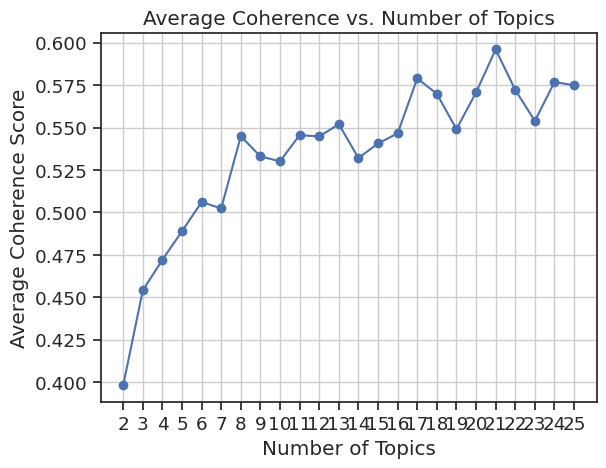

In [14]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model
import matplotlib.pyplot as plt

def plot_topic_coherence(start, end, data):

    # Initialize an empty list to store the average coherence scores
    avg_coherence_scores = []
    # Generate a list of numbers representing the range of topics
    num_topics_list = range(start, end + 1)

    # Loop through each topic number
    for num_topics in num_topics_list:
        # Initialize an LDA model with the current number of topics
        model = tp.LDAModel(k=num_topics)

        # Add each document to the model
        for text in data:
            model.add_doc(text.strip().split())

        # Specify the number of training iterations
        iterations = 10

        # Train the model iteratively
        [model.train(iterations) for _ in range(iterations)]

        # Calculate the coherence score for the model
        coherence = tp.coherence.Coherence(model, coherence='c_v')
        avg_coherence_scores.append(coherence.get_score())

    # Plot the average coherence scores against the number of topics
    plt.plot(num_topics_list, avg_coherence_scores, marker='o')
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence Score')
    plt.xticks(num_topics_list)
    plt.grid(True)
    plt.show()

# Visualize coherence scores across a spectrum of topic numbers (from 2 to 25)
plot_topic_coherence(2, 25, training_data)


### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [15]:
# Print the length of the topics list
print("Length of topics:", len(topics))
# Print the topics with their corresponding indices
print("Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i}: {topic}")

Length of topics: 10
Topics:
Topic 0: border must amp law people president national trump today american federal government stand security country
Topic 1: president great jobs america economy trump amp country ever history years american back since new
Topic 2: trump fbi russia amp collusion witch mueller hunt campaign hillary repo obama clinton president investigation
Topic 3: biden joe trump would new president york amp years like even sleepy pay china get
Topic 4: democrats president election vote house impeachment people senate trump want republicans nothing cou amp republican
Topic 5: health care people must need tax right americans trump country million republicans bill make american
Topic 6: great thank state amp vote total big endorsement job america strong military maga today complete
Topic 7: united states china trade president deal war great many amp us iran world countries mexico
Topic 8: news fake media amp people good bad never even big much many great like watch
Topic 9

In [16]:
# Q7a (code)

# Create a list comprehension to iterate over each document (doc) in the model.docs list
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

# Importing necessary modules
from IPython.display import Markdown, display

# Function to display Markdown formatted text
def make_md(string):
    display(Markdown(str(string)))

# Function to get top documents for a given topic
def get_top_docs(docs, topic_distributions, topic_index, n=5):
    # Sorting the documents based on the probability of the topic distribution
    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    # Extracting the words associated with the topic
    topic_words = topics[topic_index]

    # Displaying the topic words in Markdown format
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    # Displaying the top documents for the topic
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        # Displaying the document with its probability
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

In [56]:
# For Sanders
get_top_docs(original_texts, topic_distributions, topic_index=5, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=9, n=5)

# For Trump
get_top_docs(original_texts, topic_distributions, topic_index=1, n=5)
get_top_docs(original_texts, topic_distributions, topic_index=8, n=5)

### ✨Topic 5✨

health care people must need tax right americans trump country million republicans bill make american



---


✨  
**Topic Probability**: 0.9412731528282166  
**Document**: in just eight weeks, 36 **million** **americans** lost their jobs. 27 **million** lost their **health** insurance.

during the worst public-**health** crisis in a century, we cannot continue to tie health **care** to employment.

medicare **must** guarantee health **care** to all. https://t.co/72janh51ug



✨  
**Topic Probability**: 0.9388943910598755  
**Document**:  i always treated the chinese virus very seriously, and have done a very good job from the beginning, including my very early decision to close the “borders” from china - against the wishes of almost all. many lives were saved. the fake news new narrative is disgraceful &amp; false!



✨  
**Topic Probability**: 0.9363148212432861  
**Document**: 🚨 14.7 **million** **americans** are still out of work. coronavirus infections are rising at an unprecedented rate. 🚨

until this crisis is over, we **must**:

💵provide $2,000 a month per person
🏥ensure medical **care** without cost
👷‍♀️guarantee workers' wages
💳extend unemployment benefits



✨  
**Topic Probability**: 0.9363148212432861  
**Document**: **trump**’s decision to cut funding to the world **health** organization—in the middle of a pandemic—endangers **american** lives. and his own officials know it.

this is a global crisis. we have got to strongly support multilateral institutions like the who to confront it.



✨  
**Topic Probability**: 0.9363148212432861  
**Document**: more than 2 out of 3 disneyland workers say they go hungry. that does not sound like the “happiest place on earth” to me. https://t.co/n1sorgbfcn



### ✨Topic 9✨

people workers must change drug americans pay wage climate america american time billion energy tax



---


✨  
**Topic Probability**: 0.9461813569068909  
**Document**: hurricane maria struck puerto rico and the virgin islands three years ago today. it is a disgrace that they have not received the full federal resources they need to recover.

we are the richest country in the world. we **must** fight to ensure that all our **people** live with dignity. https://t.co/gwoojrr4pt



✨  
**Topic Probability**: 0.9421482086181641  
**Document**: more than 1.5 million children went homeless during the school year.

three **people** now own more wealth than half of **america** combined.

is this the kind of society and economy we want to live in? https://t.co/npjlr3h2ta



✨  
**Topic Probability**: 0.9374615550041199  
**Document**: sen. van hollen is absolutely right. we should block consideration of all bills on the senate floor until we end the trump shutdown and reopen the federal government.



✨  
**Topic Probability**: 0.9374615550041199  
**Document**: our fight to end the fossil fuel industry’s destruction of our planet is not going away anytime soon.

even the geniuses on wall street are starting to figure that out. https://t.co/5gdo6uophh



✨  
**Topic Probability**: 0.9374615550041199  
**Document**: billionaire wall street investors think they’re pretty savvy. but their big bet on fossil fuels didn’t pan out: blackrock lost $90 **billion** investing in oil and coal over 10 years. 

maybe after a few **billion** more in losses, they’ll realize we should act to solve **climate** **change**.



### ✨Topic 1✨

president great jobs america economy trump amp country ever history years american back since new



---


✨  
**Topic Probability**: 0.9509329199790955  
**Document**:  our justice department must not let awan &**amp**; debbie wasserman schultz off the hook. the democrat i.t. scandal is a key to much of the corruption we see today. they want to make a “plea deal” to hide what is on their server. where is server? really bad!



✨  
**Topic Probability**: 0.9475122094154358  
**Document**:  jon kyl will be an extraordinary senator representing an extraordinary state, arizona. i look forward to working with him!



✨  
**Topic Probability**: 0.9475122094154358  
**Document**:  jim mattis calls woodward book 'fiction': 'product of someone's rich imagination' https://t.co/hgmdih98nx via @breitbartnews



✨  
**Topic Probability**: 0.9390080571174622  
**Document**:  make **america** **great** again!



✨  
**Topic Probability**: 0.9364332556724548  
**Document**:  rt @reuters: roche gets fda emergency use approval for covid-19 antibody test https://t.co/vo7nak58ox https://t.co/ekbcjuupu7



### ✨Topic 8✨

news fake media amp people good bad never even big much many great like watch



---


✨  
**Topic Probability**: 0.9492344260215759  
**Document**:  the **fake** **news** networks, those that knowingly have a sick and biased agenda, are worried about the competition and quality of sinclair broadcast. the “fakers” at cnn, nbc, abc &**amp**; cbs have done so **much** dishonest reporting that they should only be allowed to get awards for fiction!



✨  
**Topic Probability**: 0.9413295388221741  
**Document**:  in new quinnipiac poll, 66% of **people** feel the economy is “excellent or **good**.” that is the highest number ever recorded by this poll.



✨  
**Topic Probability**: 0.9413295388221741  
**Document**:  i want to thank my @cabinet for working tirelessly on behalf of our country. 2017 was a year of monumental achievement and we look forward to the year ahead. together, we are delivering results and making america **great** again! https://t.co/ptxa1hapww https://t.co/yv6ralkqf3



✨  
**Topic Probability**: 0.9363759160041809  
**Document**:  a lot of very **good** **people** were taken down by a small group of dirty (filthy) cops, politicians, government officials, and an investigation that was illegally started &**amp**; that spied on my campaign. the witch hunt is sputtering badly, but still going on (ukraine hoax!). if this....



✨  
**Topic Probability**: 0.9234494566917419  
**Document**:  do you think it’s just luck that gas prices are so low, and falling? low gas prices are **like** another tax cut!



Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

In [18]:
# Q7b (words)

**For Sanders:**    
Topic 5 - Healthcare: 4 of the top 5 documents are from Sanders.  
This topic closely resonates with Sanders' political agenda, emphasizing healthcare as a fundamental right. Sanders advocates for implementing universal healthcare to ensure affordable access for all. This aligns with his focus on addressing the needs of the people and prioritizing healthcare as a critical issue.

Topic 9 - People, workers, change: all of the top 5 documents are from Sanders.  
Sanders is renowned for championing workers' rights, income equality, and environmental reform. This topic likely encompasses his push for policies like raising the minimum wage and combating climate change, which reflects his progressive ideals and commitment to socioeconomic justice.

**For Trump:**  
Topic 1 - President, great, jobs, America: all of the top 5 documents are from Trump.  
This topic encapsulates Trump's frequent messaging about his presidency's successes, particularly in job creation and national prosperity. Trump often highlights his economic achievements and pledges to prioritize American interests, resonating with his overarching narrative of making America great again.

Topic 8 - News, fake media: all of the top 5 documents are from Trump.   
Trump's contentious relationship with the mainstream media is evident in this topic, reflecting his persistent accusations of "fake news" and bias. It illustrates his efforts to shape public perception through alternative media channels, underscoring his adversarial stance towards traditional press outlets.

**Reference:**  
Macaulay, M. (2019). Bernie and the Donald: A Comparison of Left- and Right-Wing Populist Discourse. In: Macaulay, M. (eds) Populist Discourse. Palgrave Macmillan, Cham. https://doi.org/10.1007/978-3-319-97388-3_6



## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [19]:
# Crete a sample of tweets
from random import sample # importing the 'sample' function from the 'random' module
# Randomly select 100 labels from 'titles' and store them in 'target_labels'
target_labels = sample(titles,100)

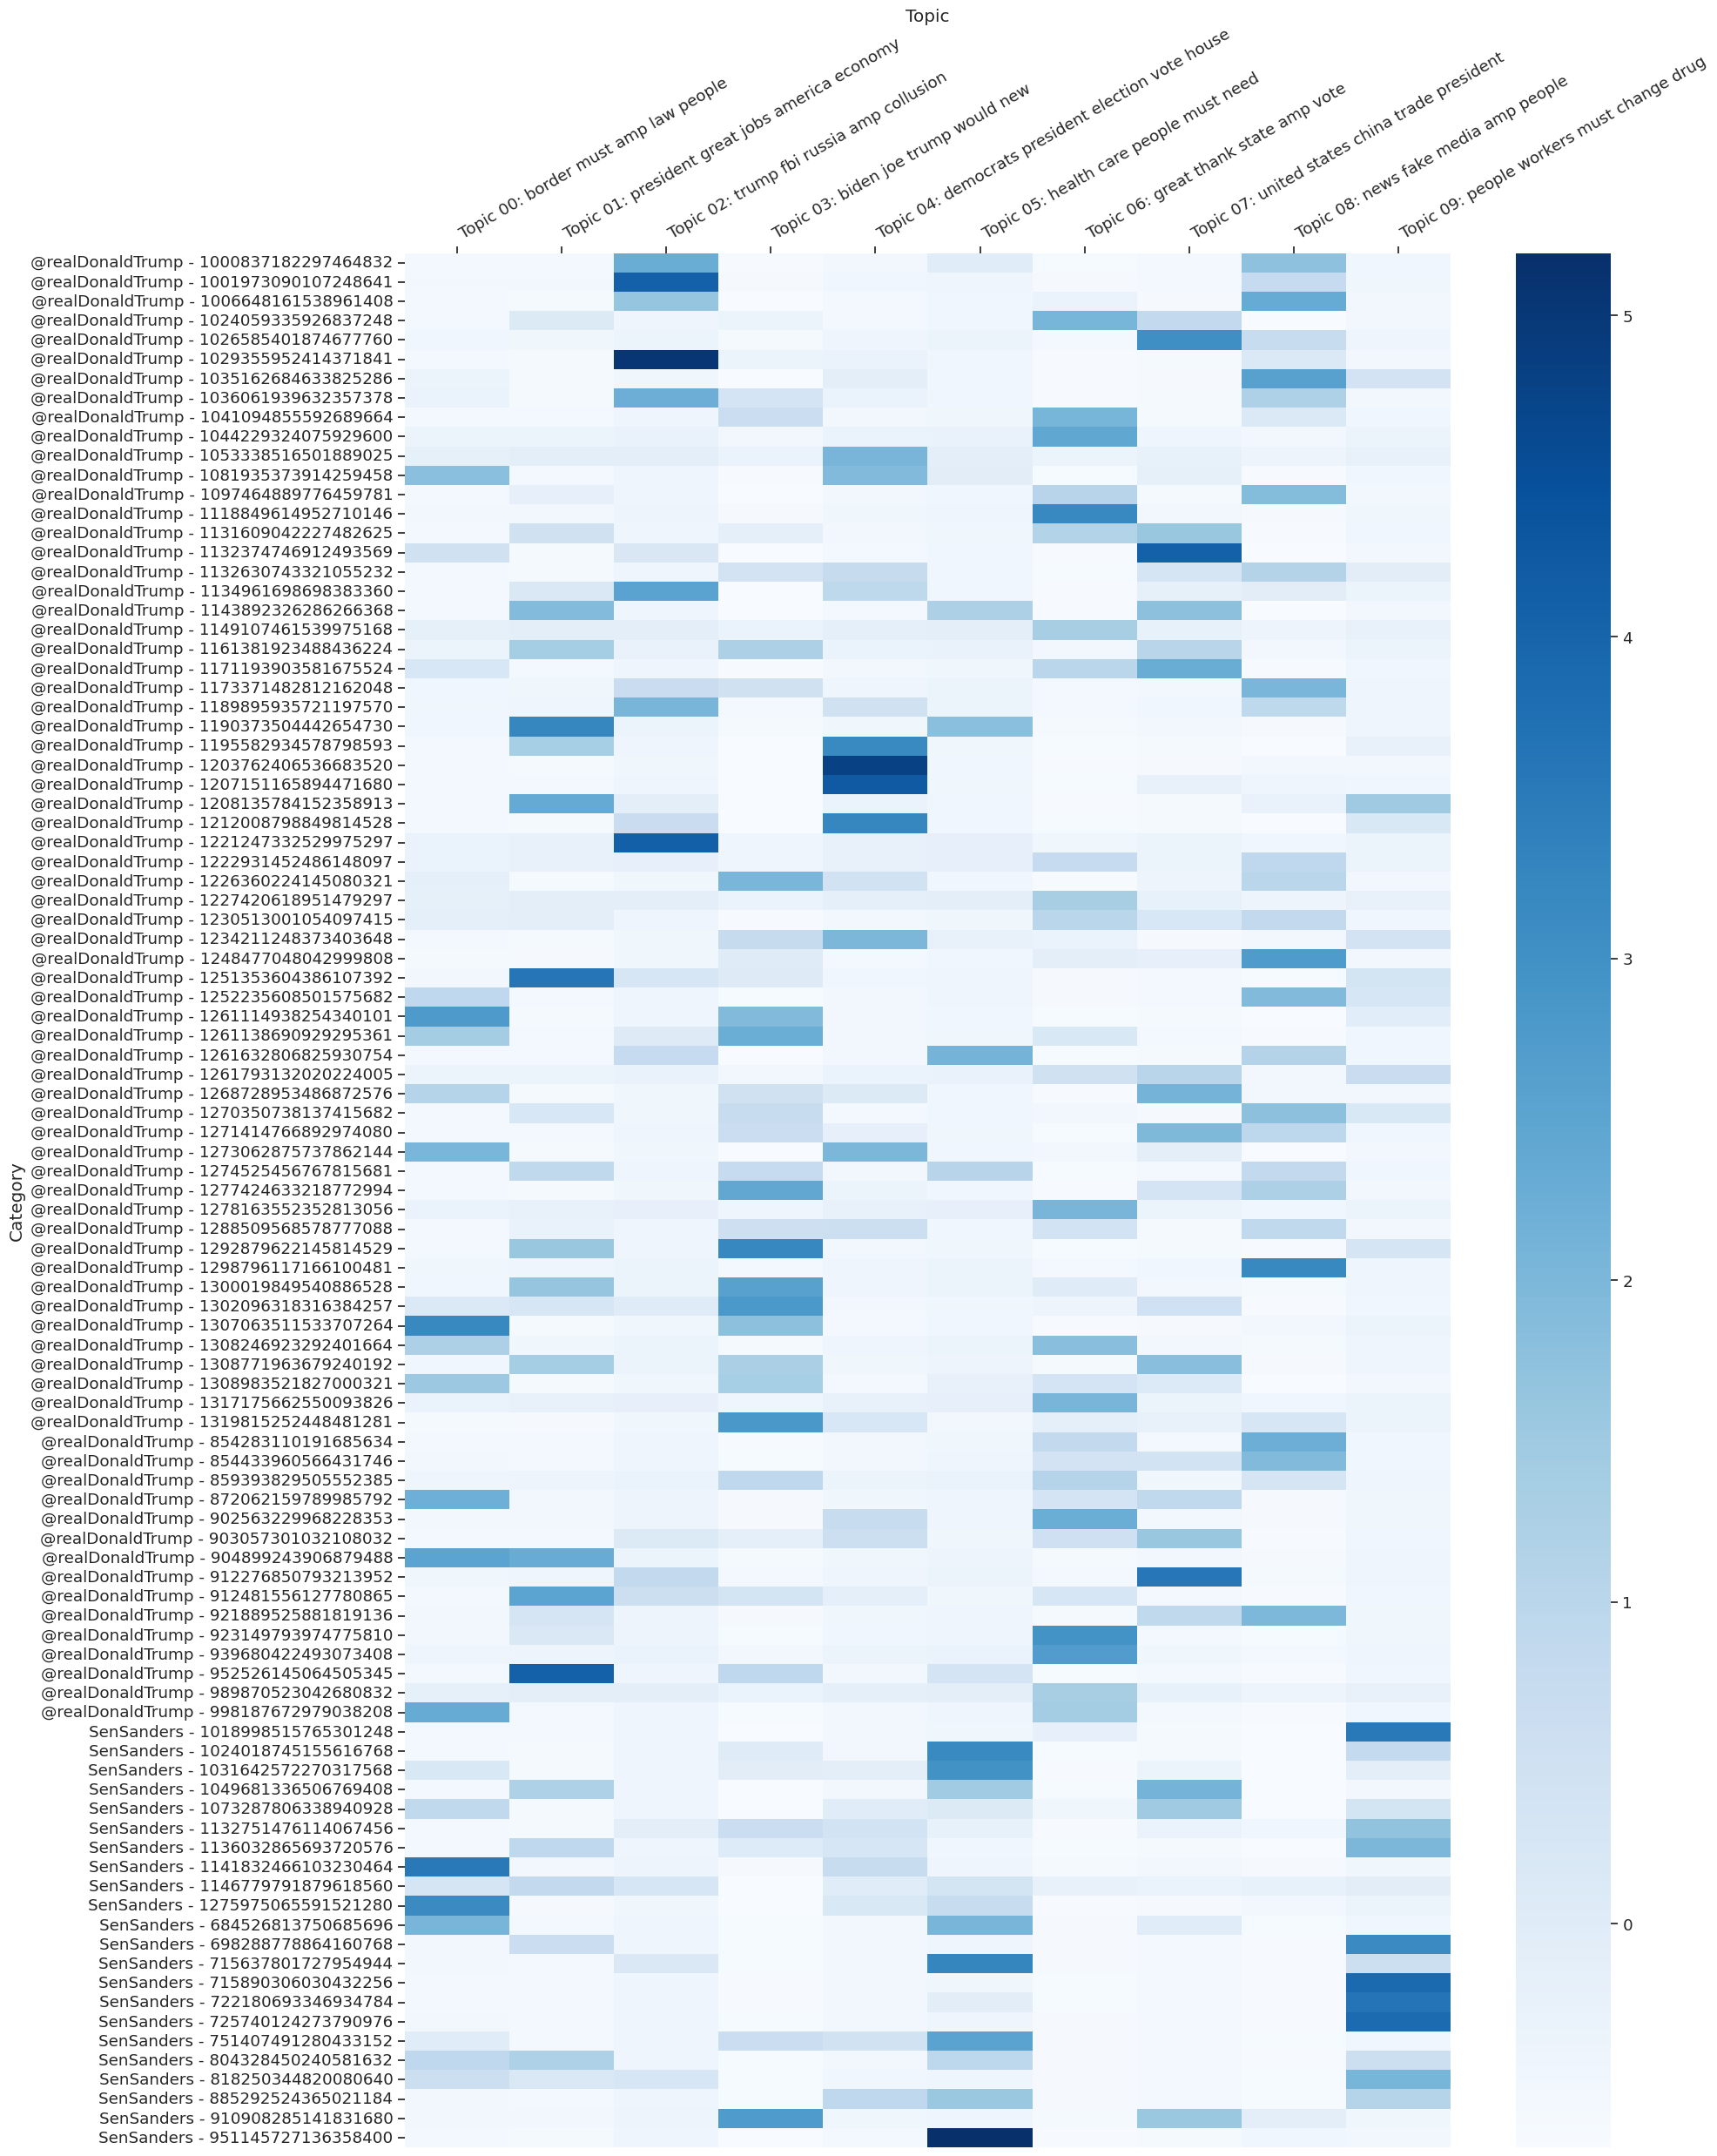

In [20]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()

# Function to generate a heatmap visualizing probability distributions of topics across categories
sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

    # Pair category labels with topic distributions in dictionaries
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})


    # Format the data into a DataFrame suitable for the heatmap and normalize the columns
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Display the final plot, adjusting font_scale to 1.2 for clarity
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

# Example function call:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                  dim=(20,25))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In [21]:
# Q9 (words)

The darker squares in this heatmap indicate a higher probability for the corresponding topic than the rest of the heatmap, while the lighter squares represent a lower probability for the corresponding topic. Analyzing the probability distributions of topics for Trump and Sanders reveals distinct patterns reflective of their personas and agendas.

Trump tends to mention topics 1, 2, 3, 4, 6, and 7, aligning with his right-wing populist approach, including national security, economic nationalism, criticisms of opponents, and assertive international relations, notably with China and Iran. This emphasis resonates with his persona as a nationalist leader prioritizing strength in domestic and foreign affairs. Additionally, Trump's extensive engagement on Twitter may also be influenced by his confident, combative, and attention-seeking personality traits.

In contrast, Sanders focuses on topics 0, 5, and 9, corresponding with his left-wing progressive ideology, centering on healthcare, social justice, workers' rights, and environmental protection. Sanders' commitment to advocating for marginalized communities and reducing inequality is evident, particularly through his emphasis on healthcare and labor rights.

While both share an interest in national security and border control (topic 0), Trump's discussions may encompass a broader range of issues, such as national defense strategies, law enforcement priorities, and broader international relations concerning border security. This broader engagement may be attributed to Trump's assertive leadership style and his tendency to address a wide array of topics to assert his political dominance and influence public discourse.

In summary, the probability distributions of topics reflect the contrasting orientations of Trump and Sanders. Trump's focus on nationalism and assertive policies aligns with his right-wing populism, while Sanders' emphasis on social justice and economic equality mirrors his left-wing progressive agenda. Additionally, Trump's broader engagement on Twitter may be influenced by his personality traits, contributing to his extensive coverage of various topics on the platform.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

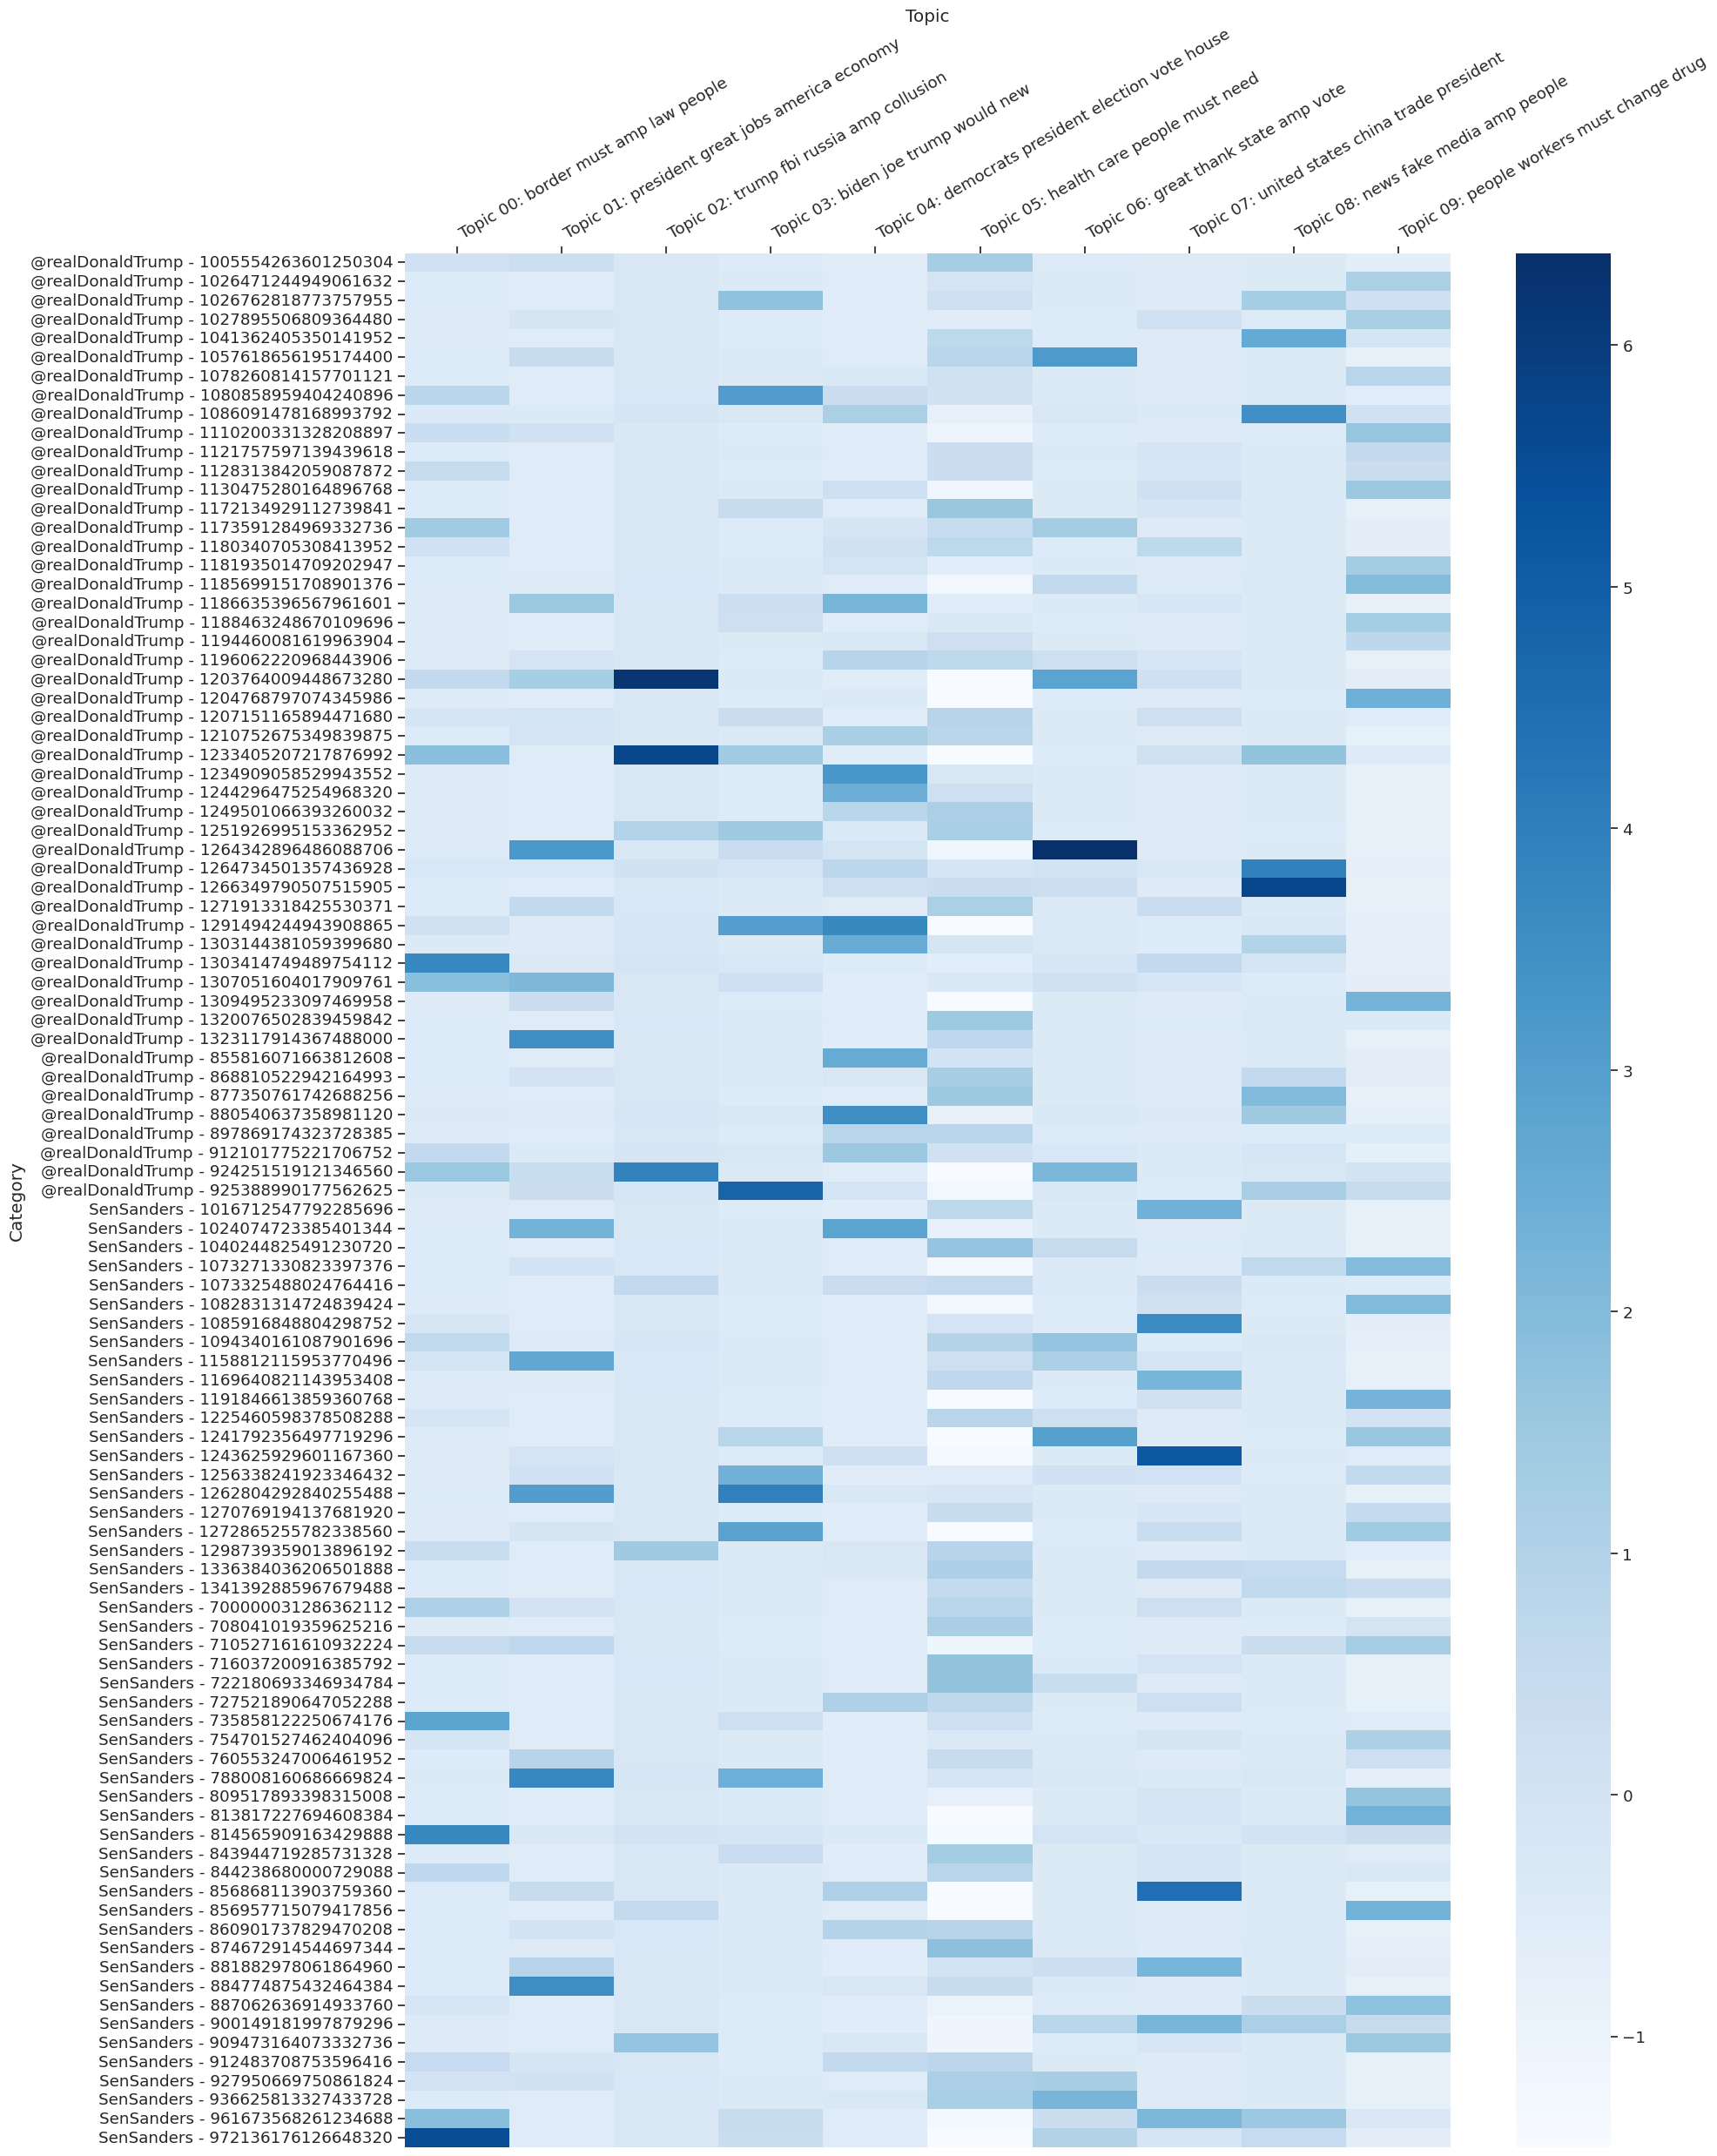

In [22]:
# X2 (code)

# Separate tweets by each candidate
trump_titles = [title for title in titles if 'Trump' in title]
sanders_titles = [title for title in titles if 'Sanders' in title]

# Sample 50 titles for each politician
trump_sample = sample(trump_titles, 50)
sanders_sample = sample(sanders_titles, 50)

# Combine the two samples to create a balanced list of 100 titles
balanced_sample = trump_sample + sanders_sample

# Call the function to plot the heatmap with the balanced sample
plot_categories_by_topics_heatmap(balanced_sample,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=balanced_sample,
                                  color_map='Blues',
                                  dim=(20, 25))

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [23]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)

In [31]:
# Combine titles and distributions into a list of dictionaries
dicts_to_plot = []
for _label, _distribution in zip(titles, topic_distributions):
    for _topic_index, _probability in enumerate(_distribution):
        dicts_to_plot.append({'Probability': float(_probability),
                              'Category': _label,
                              'Topic': 'Topic ' + str(_topic_index+1).zfill(2) + ': ' + ' '.join(topic_individual_words[_topic_index][:5])})

# Create a DataFrame from the list of dictionaries
dicts_to_plot = pd.DataFrame(dicts_to_plot)

# Pivot the DataFrame for the heatmap
df_wide = df_to_plot.pivot_table(index='Category',
                                 columns='Topic',
                                 values='Probability')

# Normalize the columns
df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

In [32]:
# Display the resulting DataFrame
df_norm_col

Topic,Topic 01: border must amp law people,Topic 02: president great jobs america economy,Topic 03: trump fbi russia amp collusion,Topic 04: biden joe trump would new,Topic 05: democrats president election vote house,Topic 06: health care people must need,Topic 07: great thank state amp vote,Topic 08: united states china trade president,Topic 09: news fake media amp people,Topic 10: people workers must change drug
Category,,,,,,,,,,
@realDonaldTrump - 1000061992042975232,-0.317966,0.689694,0.742622,-0.509875,0.291512,-0.556076,-0.570462,1.414777,-0.579885,-0.488959
@realDonaldTrump - 1000064605903876096,-0.579954,0.591329,-0.241433,-0.235350,0.431406,-0.558982,-0.387936,-0.540999,2.175533,-0.491370
@realDonaldTrump - 1000114139136606209,-0.567759,-0.567806,1.556406,3.080248,-0.617093,-0.290654,-0.563203,-0.530225,-0.571192,-0.216284
@realDonaldTrump - 1000138164923781121,0.834339,-0.572663,-0.197229,2.433446,0.876043,-0.552657,-0.567152,-0.534450,-0.575922,-0.486123
@realDonaldTrump - 1000145873274359809,-0.525988,-0.525386,-0.428580,2.706914,0.396344,-0.512935,-0.528708,-0.493323,1.044950,-0.453176
...,...,...,...,...,...,...,...,...,...,...
SenSanders - 999363693623349248,-0.581473,-0.581734,-0.465319,0.288503,-0.631555,-0.174848,0.675987,0.328251,-0.141565,1.100280
SenSanders - 999681965526798336,1.704754,-0.247398,-0.454414,-0.499217,-0.614187,0.808889,-0.309692,-0.527791,0.678087,-0.480789
SenSanders - 999681967720460288,0.670308,0.645526,-0.444790,1.403660,-0.598861,-0.533824,-0.548926,0.253309,-0.162995,-0.119125


In [52]:
# Filtering tweets for Trump and Sanders
tweets_trump = df_wide[df_wide.index.str.contains('@realDonaldTrump')]
tweets_sanders = df_wide[df_wide.index.str.contains('SenSanders')]

# Calculating mean topic probabilities for Trump and Sanders
topic_means_trump = tweets_trump.mean()
topic_means_sanders = tweets_sanders.mean()

<ipython-input-53-934778efe8fc>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


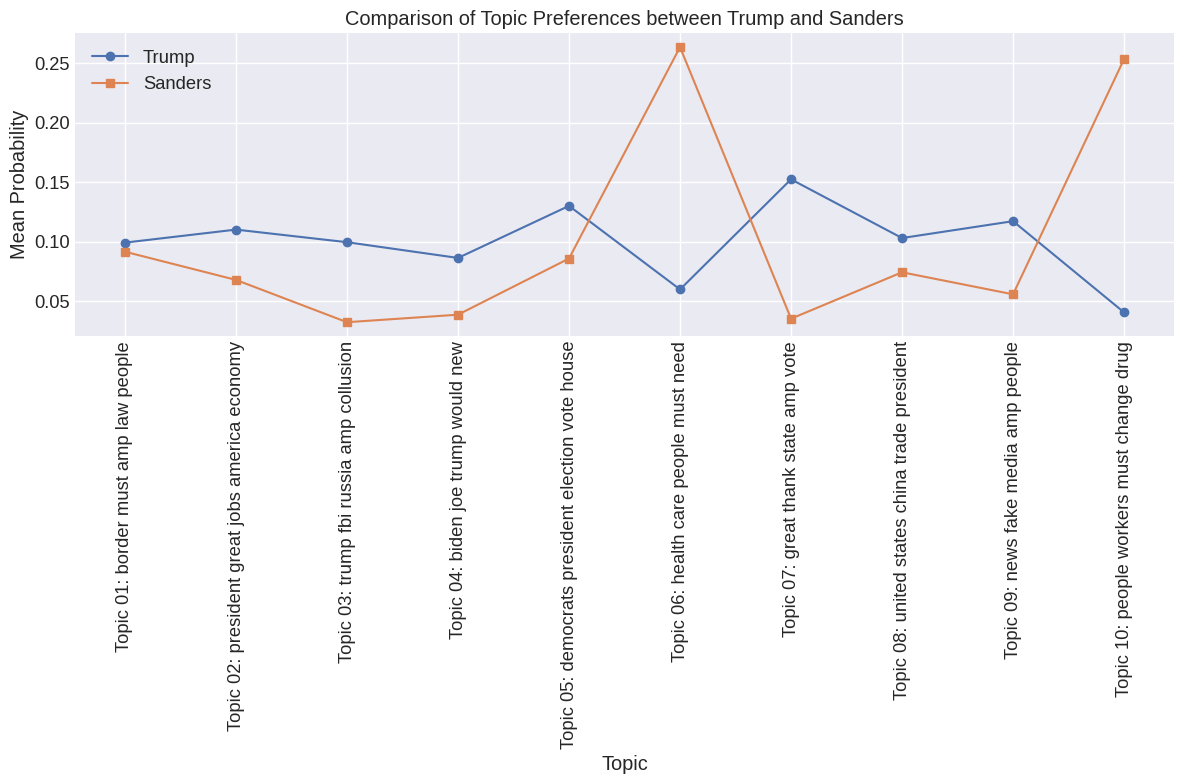

In [53]:
# Set plot style and font size
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})  # Set the font size to 12

# Set the size
plt.figure(figsize=(12, 8))

# Plot the topic preferences comparison between Trump and Sanders
plt.plot(topic_means_trump, label='Trump', marker='o')
plt.plot(topic_means_sanders, label='Sanders', marker='s')

# Add labels and title
plt.title('Comparison of Topic Preferences between Trump and Sanders')
plt.xlabel('Topic')
plt.ylabel('Mean Probability')
plt.xticks(range(len(topic_means_trump)), topic_means_trump.index, rotation=90)  # Set x-axis ticks as topic labels and rotate to avoid overlap
plt.legend()  # add legend
plt.tight_layout()  # automatically adjust layout to prevent label overlap

# Display the plot
plt.show()

The line chart provides valuable insights into the primary Twitter topics and political orientations of both Trump and Sanders.

The dominance of the blue line representing Trump over the orange line of Sanders clearly indicates Trump's broader engagement with Twitter topics. This tendency likely stems from his assertive personality and right-wing populist stance, seen in his focus on topics like national security (Topic 0), economic nationalism (Topic 1), and trade relations with China (Topic 7). Trump's outspoken nature likely drives his extensive coverage of these topics, showcasing his commitment to nationalist policies and strong leadership.

In contrast, Sanders' focus, depicted by the orange line, appears more targeted, primarily on specific topics related to social justice, healthcare, and environmental protection. For instance, his emphasis on healthcare as a fundamental right (Topic 5) and addressing income inequality (Topic 9) aligns with his left-wing progressive ideology.

Additionally, when delving into subjects like expressing gratitude and support for the nation (Topic 6) and international trade and relations (Topic 7), Trump's and Sanders' curves portray strikingly different patterns. This highlights how their trajectories sharply diverge, especially on topics such as Topic 6, 7, and 10, providing a clear illustration of how their vastly different political stances lead to opposing topic preferences.